## Retrieving Images and Searching Using Image Descriptors

Similar to the human eyes and brain, OpenCV can detect the main features of an image and extract them into so-called image descriptors. These features can then be used as a database, enabling image-based searches. Moreover, we can use key points to stitch images together and compose a bigger image

we will take sample images and detect their main features, and then try to find a region of another image that matches the sample image. We will also find the homography or spatial relationship between a sample image and a matching region of another image.More specifically, we will cover the following tasks:

- Detecting keypoints and extracting local descriptors around the keypoints using any of the following algorithms: Harris corners, SIFT, SURF, or ORB
- Matching keypoints using brute-force algorithms or the FLANN algorithm
- Filtering out bad matches using KNN and the ratio test
- Finding the homography between two sets of matching keypoints
- Searching a set of images to determine which one contains the best match for a reference image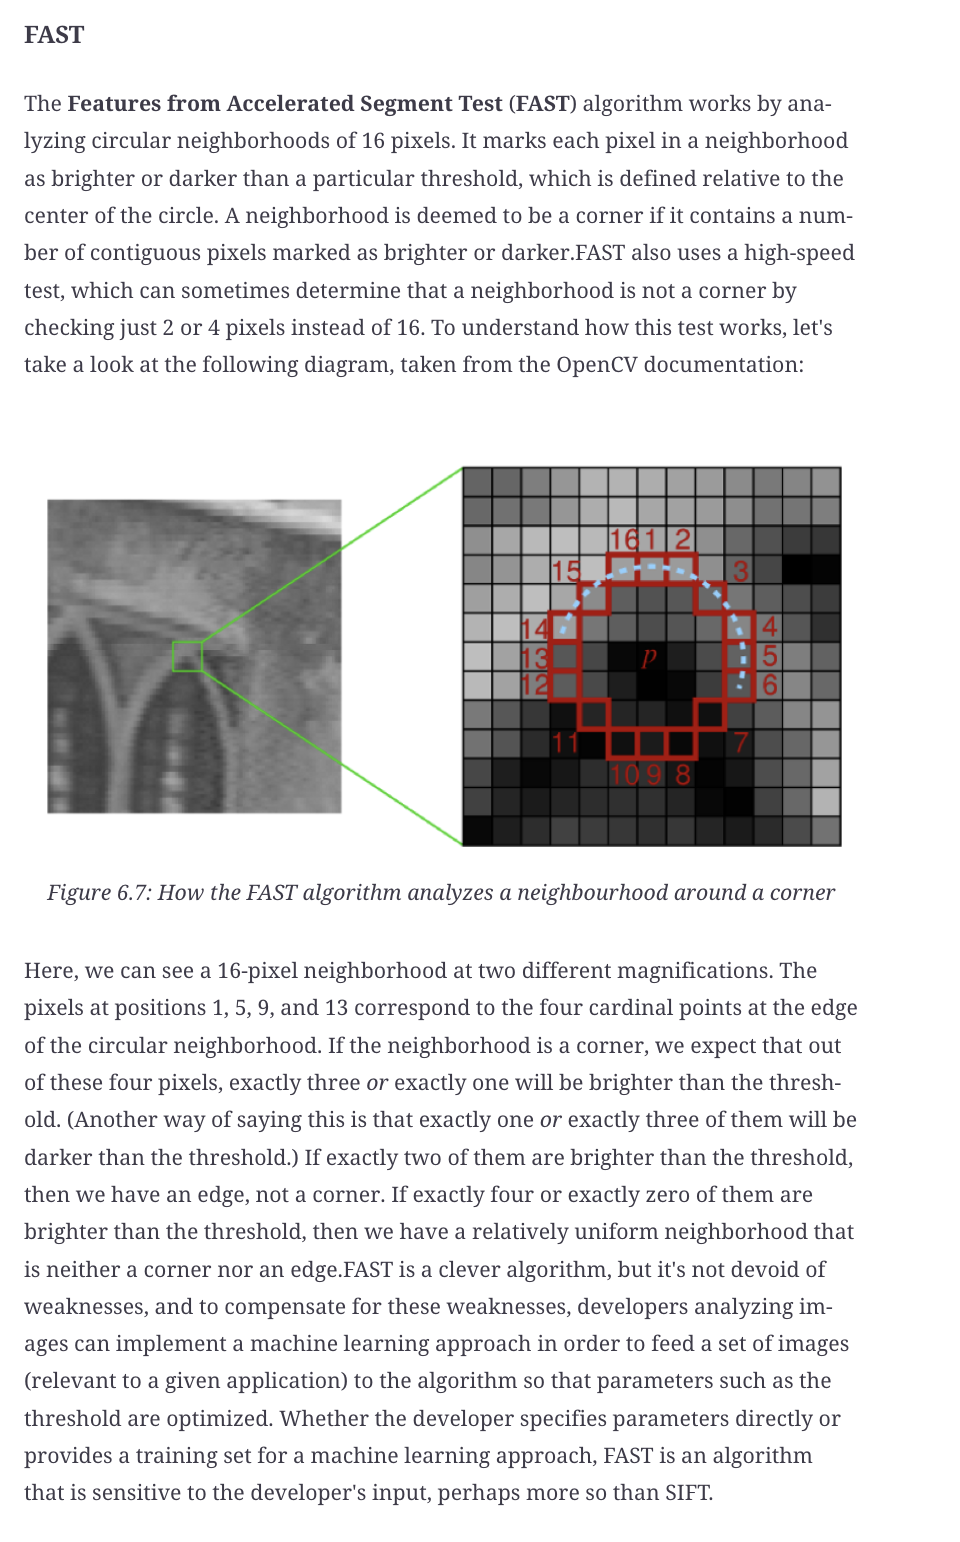

## Understanding types of feature detection and matching

- Harris: This algorithm is useful for detecting corners.
- SIFT: This algorithm is useful for detecting blobs.
- SURF: This algorithm is useful for detecting blobs.
- FAST: This algorithm is useful for detecting corners.
- BRIEF: This algorithm is useful for detecting blobs.
- ORB: This algorithm stands for Oriented FAST and Rotated BRIEF. It is useful for detecting a combination of corners and blobs.

Matching features can be performed with the following methods:

- Brute-force matching
- FLANN-based matching

### Defining features

What defines a feature, you may wonder? Why does one part of an image qualify as a feature while others do not? In essence, a feature represents a distinctive or easily discernible area of interest within the image. Optimal features include corners and regions rich in textural intricacies, as they stand out, whereas repetitive patterns and low-density zones, like a serene blue sky, are less suitable. Edges are noteworthy features, marking the boundaries between areas with abrupt changes in intensity, be it in grayscale or color values.

Consider a blob—an area in an image that markedly differs from its surroundings—an intriguing feature in itself. Many feature detection algorithms center around pinpointing corners, edges, and blobs. Some even delve into the concept of a ridge, envisioning it as the axis of symmetry for an elongated object (imagine identifying a road in an image, for instance).

Notably, various algorithms excel at recognizing and extracting specific types of features. Knowing the nature of your input image allows you to wield the most effective tool from your OpenCV arsenal, ensuring a tailored and precise approach to feature identification.

In [1]:
!git clone https://github.com/PacktPublishing/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition.git

Cloning into 'Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition'...
remote: Enumerating objects: 1932, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1932 (delta 183), reused 341 (delta 180), pack-reused 1576
Receiving objects: 100% (1932/1932), 286.50 MiB | 22.70 MiB/s, done.
Resolving deltas: 100% (779/779), done.
Updating files: 100% (422/422), done.


In [2]:
!pip install opencv-contrib-python --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.8.0.76
    Uninstalling opencv-contrib-python-4.8.0.76:
      Successfully uninstalled opencv-contrib-python-4.8.0.76


In [3]:
import os

import cv2
import numpy
import PIL.Image

from IPython import display
from urllib.request import urlopen


def cv2_imshow(winname, mat):
    mat = mat.clip(0, 255).astype('uint8')
    if mat.ndim == 3:
        if mat.shape[2] == 4:
            mat = cv2.cvtColor(mat, cv2.COLOR_BGRA2RGBA)
        else:
            mat = cv2.cvtColor(mat, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(mat))

cv2.imshow = cv2_imshow


def cv2_waitKey(delay=0):
    return -1

cv2.waitKey = cv2_waitKey


def cv2_imread(filename, flags=cv2.IMREAD_COLOR):
    if os.path.exists(filename):
        image = cv2._imread(filename, flags)
    else:
        url = f'https://github.com/PacktPublishing/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/raw/main/*/{filename}'
        resp = urlopen(url)
        image = numpy.asarray(bytearray(resp.read()), dtype='uint8')
        image = cv2.imdecode(image, flags)
    return image

# Cache the original implementation of `imread`, if we have not already
# done so on a previous run of this cell.
if '_imread' not in dir(cv2):
    cv2._imread = cv2.imread

cv2.imread = cv2_imread

## Detecting Harris corners
Let's start by finding corners using the Harris corner detection algorithm.



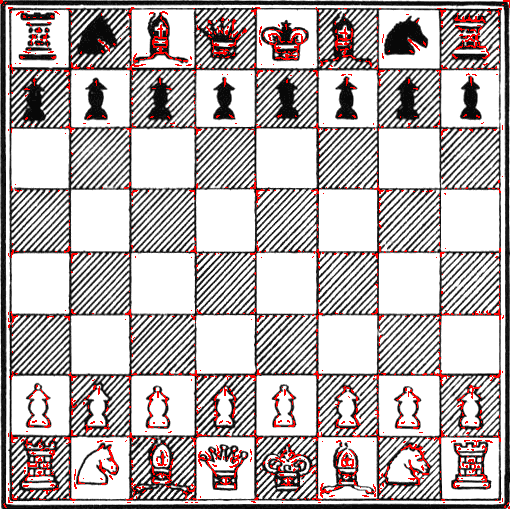

-1

In [5]:
import cv2

img = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/chess_board.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dst = cv2.cornerHarris(gray, 2, 23, 0.04)
##  select pixels with scores that are at least 1% of the highest score
img[dst > 0.01 * dst.max()] = [0, 0, 255]
cv2.imshow('corners', img)
cv2.waitKey()

we call the cornerHarris function:
```
dst = cv2.cornerHarris(gray, 2, 23, 0.04)

```
The Sobel operator detects edges by measuring horizontal and vertical differences between pixel values in a neighborhood, and it does this using a kernel. The cv2.cornerHarris function uses a Sobel operator whose aperture is defined by this parameter. In plain English, the parameters define how sensitive corner detection is. It must be between 3 and 31 and be an odd value. With a low (highly sensitive) value of 3, all those diagonal lines in the black squares of the chessboard will register as corners when they touch the border of the square. For a higher (less sensitive) value of 23, only the corners of each square will be detected as corners.cv2.cornerHarris returns an image in floating-point format. Each value in this image represents a score for the corresponding pixel in the source image.

If we tweak the second parameter in cv2.cornerHarris, we will see that smaller regions (for a smaller parameter value) or larger regions (for a larger parameter value) will be detected as corners. This parameter is called the block size.

## Detecting DoG features and extracting SIFT descriptors

The preceding technique, which uses cv2.cornerHarris, is great for detecting corners and has a distinct advantage because even if the image is rotated corners are still the corners. However, if we scale an image to a smaller or larger size, some parts of the image may lose or even gain a corner quality

If we further reduce the image, at some scale, we will lose the entrance to that chicane too.This loss of features raises an issue; we need an algorithm that works regardless of the scale of the image. Enter Scale-Invariant Feature Transform (SIFT). While the name may sound a bit mysterious, now that we know what problem we are trying to solve, it actually makes sense. We need a function (a transform) that will detect features (a feature transform) and will not output different results depending on the scale of the image (a scale-invariant feature transform). Note that SIFT does not detect keypoints. Keypoint detection is done with the Difference of Gaussians (DoG)(**we talked about low pass filters and blurring operations, and specifically the cv2.GaussianBlur function. DoG is the result of applying different Gaussian filters to the same image**)

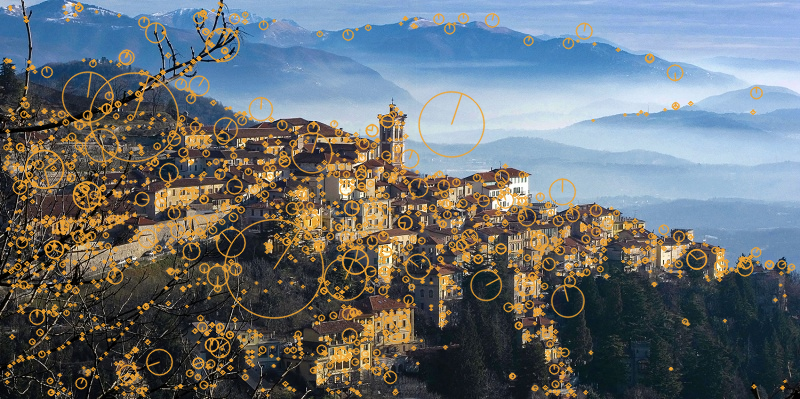

-1

In [6]:
# %load sift.py
import cv2

img = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/varese.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray, None)

cv2.drawKeypoints(img, keypoints, img, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imshow('sift_keypoints', img)
cv2.waitKey()

The final result of a DoG operation contains areas of interest (keypoints), which are then going to be described through SIFT.Let's see how DoG and SIFT behave in the following image, which is full of corners and features(as shown above)

As the name of the detectAndCompute method clearly suggests, two main operations are performed: feature detection and the computation of descriptors. The return value of the operation is a tuple containing a list of keypoints and another list of the keypoints' descriptors.Finally, we process this image by drawing the keypoints on it with the cv2.drawKeypoints function and then displaying it with the usual cv2.imshow function

### Anatomy of a keypoint
Each keypoint is an instance of the cv2.KeyPoint class, which has the following properties:

- The pt (point) property contains the x and y coordinates of the keypoint in the image.
- The size property indicates the diameter of the feature.
- The angle property indicates the orientation of the feature, as shown by the radial lines in the preceding processed image.
- The response property indicates the strength of the keypoint. Some features are classified by SIFT as stronger than others, and response is the property you would check to evaluate the strength of a feature.
- The octave property indicates the layer in the image pyramid where the feature was found. The SIFT algorithm operates in a similar fashion to face detection algorithms(Haar cascades) in that it processes the same image iteratively but alters the input at each iteration. In particular, the scale of the image is a parameter that changes at each iteration (octave) of the algorithm. Thus, the octave property is related to the image scale at which the keypoint was detected.
Finally, the class_id property can be used to assign a custom identifier to a keypoint or a group of keypoints.

## Detecting Fast Hessian features and extracting SURF descriptors

```
import cv2
img = cv2.imread('../images/varese.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
surf = cv2.xfeatures2d.SURF_create(8000)
keypoints, descriptor = surf.detectAndCompute(gray, None)
cv2.drawKeypoints(img, keypoints, img, (51, 163, 236),
                  cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow('surf_keypoints', img)
cv2.waitKey()

```
The parameter to cv2.xfeatures2d.SURF_create is a threshold for the Fast Hessian algorithm. By increasing the threshold, we can reduce the number of features that will be retained



## Using ORB with FAST features and BRIEF descriptors
If SIFT is young, and SURF younger, ORB is in its infancy. ORB was first published in 2011 as a fast alternative to SIFT and SURF.The algorithm was published in the paper ORB: an efficient alternative to SIFT or SURF, available in PDF format at http://www.willowgarage.com/sites/default/files/orb_final.pdf.ORB mixes the techniques used in the FAST keypoint detector and the BRIEF keypoint descriptor, so it is worth taking a quick look at FAST and BRIEF first.

### FAST
The Features from Accelerated Segment Test (FAST) algorithm works by analyzing circular neighborhoods of 16 pixels. It marks each pixel in a neighborhood as brighter or darker than a particular threshold, which is defined relative to the center of the circle. A neighborhood is deemed to be a corner if it contains a number of contiguous pixels marked as brighter or darker.FAST also uses a high-speed test, which can sometimes determine that a neighborhood is not a corner by checking just 2 or 4 pixels instead of 16.

## BRIEF
Binary Robust Independent Elementary Features (BRIEF), on the other hand, is not a feature detection algorithm, but a descriptor. Let's delve deeper into the concept of what a descriptor is, and then look at BRIEF.When we previously analyzed images with SIFT and SURF, the heart of the entire process was the call to the detectAndCompute function. **This function performs two different steps – detection and computation – and they return two different results, coupled in a tuple.The result of detection is a set of keypoints; the result of the computation is a set of descriptors for those keypoints.** This means that OpenCV's cv2.SIFT and cv2.xfeatures2d.SURF classes implement algorithms for both detection and description. Remember, though, that the original SIFT and SURF are not feature detection algorithms. OpenCV's cv2.SIFT implements DoG feature detection plus SIFT description, while OpenCV's cv2.xfeatures2d.SURF implements Fast Hessian feature detection plus SURF description.Keypoint descriptors are a representation of the image that serves as the gateway to feature matching because you can compare the keypoint descriptors of two images and find commonalities.BRIEF is one of the fastest descriptors currently available. The theory behind BRIEF is quite complicated, but suffice it to say that BRIEF adopts a series of optimizations that make it a very good choice for feature matching.

## Brute-force matching
A brute-force matcher is a descriptor matcher that compares two sets of keypoint descriptors and generates a result that is a list of matches. It is called brute-force because little optimization is involved in the algorithm. For each keypoint descriptor in the first set, the matcher makes comparisons to every keypoint descriptor in the second set. Each comparison produces a distance value and the best match can be chosen on the basis of least distance.More generally, in computing, the term brute-force is associated with an approach that prioritizes the exhaustion of all possible combinations (for example, all the possible combinations of characters to crack a password of a known length).

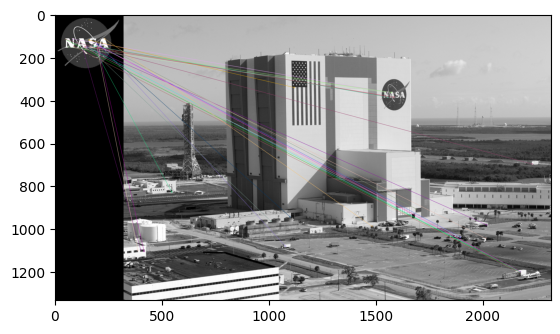

In [7]:
# %load orb.py
import cv2
from matplotlib import pyplot as plt

# Load the images.
img0 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/nasa_logo.png',
                  cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/kennedy_space_center.jpg',
                  cv2.IMREAD_GRAYSCALE)

# Perform ORB feature detection and description.
orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)

# Perform brute-force matching.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des0, des1)

# Sort the matches by distance.
matches = sorted(matches, key=lambda x:x.distance)

# Draw the best 25 matches.
img_matches = cv2.drawMatches(
    img0, kp0, img1, kp1, matches[:25], img1,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the matches.
plt.imshow(img_matches)
plt.show()

## Filtering matches using K-Nearest Neighbors and the ratio test
We can eliminate many false positive matches by performing KNN matching with the ratio test (whereby we reject a dubious "best" match if it is not much better than a "second-best" match).

Run the following script, which first computes a large set of matches and then filters them, again using the NASA logo and Kennedy Space Center as subjects:

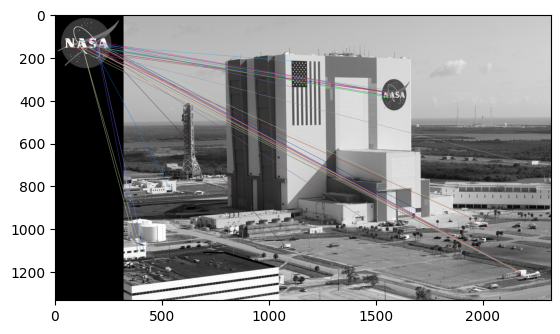

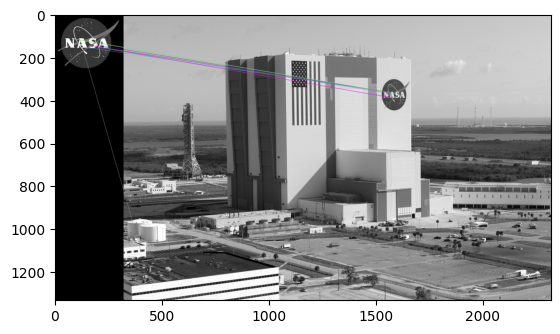

In [8]:
# %load orb_knn.py
import cv2
from matplotlib import pyplot as plt

# Load the images.
img0 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/nasa_logo.png',
                  cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/kennedy_space_center.jpg',
                  cv2.IMREAD_GRAYSCALE)


# Perform ORB feature detection and description.
orb = cv2.ORB_create()
kp0, des0 = orb.detectAndCompute(img0, None)
kp1, des1 = orb.detectAndCompute(img1, None)

# Perform brute-force KNN matching.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
pairs_of_matches = bf.knnMatch(des0, des1, k=2)

# Sort the pairs of matches by distance.
pairs_of_matches = sorted(pairs_of_matches, key=lambda x:x[0].distance)

# Draw the 25 best pairs of matches.
img_pairs_of_matches = cv2.drawMatchesKnn(
    img0, kp0, img1, kp1, pairs_of_matches[:25], img1,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the pairs of matches.
plt.imshow(img_pairs_of_matches)
plt.show()

# Apply the ratio test.
matches = [x[0] for x in pairs_of_matches
           if len(x) > 1 and x[0].distance < 0.8 * x[1].distance]

# Draw the best 25 matches.
img_matches = cv2.drawMatches(
    img0, kp0, img1, kp1, matches[:25], img1,
    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# Show the matches.
plt.imshow(img_matches)
plt.show()

## Matching with FLANN
Similarly, we can combine KNN matching and the ratio test with FLANN-based matching instead of brute-force matching.

FLANN stands for Fast Library for Approximate Nearest Neighbors. It is an open source library under the permissive 2-clause BSD license and it is available on GitHub at https://github.com/flann-lib/flann. There, we find the following description:

"FLANN is a library for performing fast approximate nearest neighbor searches in high dimensional spaces. It contains a collection of algorithms we found to work best for the nearest neighbor search and a system for automatically choosing the best algorithm and optimum parameters depending on the dataset. FLANN is written in C++ and contains bindings for the following languages: C, MATLAB,Python, and Ruby."

Run the following script, which finds matches between images of Gaugin paintings:

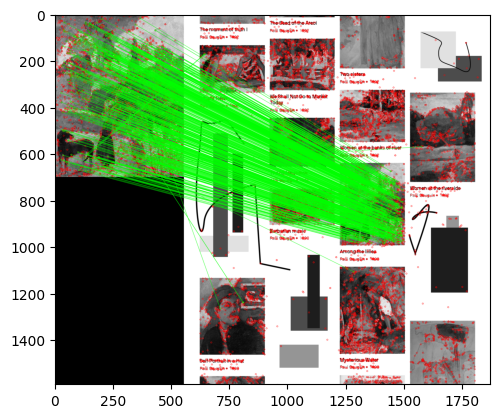

In [9]:
# %load flann.py
import numpy as np
import cv2
from matplotlib import pyplot as plt

img0 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/gauguin_entre_les_lys.jpg',
                  cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/gauguin_paintings.png',
                  cv2.IMREAD_GRAYSCALE)

# Perform SIFT feature detection and description.
sift = cv2.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)

# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

# Prepare an empty mask to draw good matches.
mask_matches = [[0, 0] for i in range(len(matches))]

# Populate the mask based on David G. Lowe's ratio test.
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        mask_matches[i]=[1, 0]

# Draw the matches that passed the ratio test.
img_matches = cv2.drawMatchesKnn(
    img0, kp0, img1, kp1, matches, None,
    matchColor=(0, 255, 0), singlePointColor=(255, 0, 0),
    matchesMask=mask_matches, flags=0)

# Show the matches.
plt.imshow(img_matches)
plt.show()

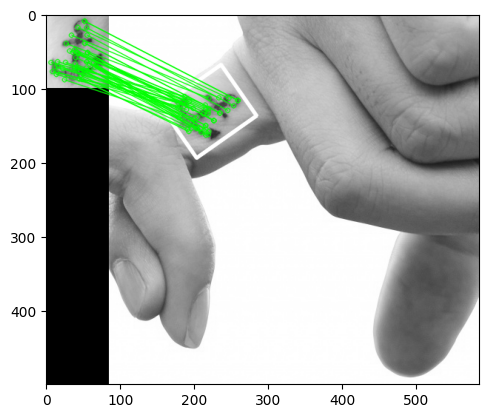

In [10]:
# %load homography.py
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_NUM_GOOD_MATCHES = 10

img0 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/tattoos/query.png',
                  cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('/content/Learning-OpenCV-5-Computer-Vision-with-Python-Fourth-Edition/images/tattoos/anchor-man.png',
                  cv2.IMREAD_GRAYSCALE)

# Perform SIFT feature detection and description.
sift = cv2.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)

# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

# Find all the good matches as per Lowe's ratio test.
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

if len(good_matches) >= MIN_NUM_GOOD_MATCHES:
    src_pts = np.float32(
        [kp0[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    mask_matches = mask.ravel().tolist()

    h, w = img0.shape
    src_corners = np.float32(
        [[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst_corners = cv2.perspectiveTransform(src_corners, M)
    dst_corners = dst_corners.astype(np.int32)

    # Draw the bounds of the matched region based on the homography.
    num_corners = len(dst_corners)
    for i in range(num_corners):
        x0, y0 = dst_corners[i][0]
        if i == num_corners - 1:
            next_i = 0
        else:
            next_i = i + 1
        x1, y1 = dst_corners[next_i][0]
        cv2.line(img1, (x0, y0), (x1, y1), 255, 3, cv2.LINE_AA)

    # Draw the matches that passed the ratio test.
    img_matches = cv2.drawMatches(
        img0, kp0, img1, kp1, good_matches, None,
        matchColor=(0, 255, 0), singlePointColor=None,
        matchesMask=mask_matches, flags=2)

    # Show the homography and good matches.
    plt.imshow(img_matches)
    plt.show()
else:
    print("Not enough matches good were found - %d/%d" % \
          (len(good_matches), MIN_NUM_GOOD_MATCHES))